---
title: "Skrub"
format:
  html:
    code-fold: false
jupyter: python3
---


[skrub-data.org](https://skrub-data.org/)

**Less wrangling, more machine learning**

# Machine learning and tabular data

- ML expects numeric arrays
- Real data is more complex:
  - Multiple tables
  - Dates, categories, text, locations, …

**Skrub: bridge the gap between dataframes and scikit-learn.**

## Skrub helps at several stages of a tabular learning project

1. What's in the data? (EDA)
1. Can we learn anything? (baselines)
1. How do I represent the data? (feature extraction)
1. How do I bring it all together? (building a pipeline)

# 1. What's in the data?

In [1]:
import skrub
from skrub import datasets

employees = datasets.fetch_employee_salaries().X
employees.iloc[0]

gender                                                                     F
department                                                               POL
department_name                                         Department of Police
division                   MSB Information Mgmt and Tech Division Records...
assignment_category                                         Fulltime-Regular
employee_position_title                          Office Services Coordinator
date_first_hired                                                  09/22/1986
year_first_hired                                                        1986
Name: 0, dtype: object


## `TableReport`: interactive display of a dataframe

In [2]:
skrub.TableReport(employees, verbose=0)

,,,,,,,,


We can tell skrub to patch the default display of polars and pandas dataframes.

In [3]:
skrub.patch_display(verbose=0)

# 2. Can we learn anything?

In [4]:
employee_salaries = datasets.fetch_employee_salaries()
X, y = employee_salaries.X, employee_salaries.y

## `tabular_learner`: a pre-made robust baseline

In [5]:
learner = skrub.tabular_learner("regressor")
learner

Pipeline(steps=[('tablevectorizer',
                 TableVectorizer(high_cardinality=MinHashEncoder(),
                                 low_cardinality=ToCategorical())),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(categorical_features='from_dtype'))])

In [6]:
from sklearn.model_selection import cross_val_score

cross_val_score(learner, X, y, scoring="r2")

array([0.89370447, 0.89279068, 0.92282557, 0.92319094, 0.92162666])

The `tabular_learner` adapts to the supervised estimator we choose

In [7]:
from sklearn.linear_model import Ridge

learner = skrub.tabular_learner(Ridge())
learner

Pipeline(steps=[('tablevectorizer', TableVectorizer()),
                ('simpleimputer', SimpleImputer(add_indicator=True)),
                ('standardscaler', StandardScaler()), ('ridge', Ridge())])

In [8]:
cross_val_score(learner, X, y, scoring="r2")

array([0.75414927, 0.7188604 , 0.74889487, 0.77203532, 0.76697897])

# 3. How do I represent the data?

Skrub helps extract informative features from tabular data.

## `TableVectorizer`: apply an appropriate transformer to each column

In [9]:
vectorizer = skrub.TableVectorizer()
transformed = vectorizer.fit_transform(X)

The `TableVectorizer` identifies several kinds of columns:

- categorical, low cardinality
- categorical, high cardinality
- datetime
- numeric
- ... we may add more

In [10]:
from pprint import pprint

pprint(vectorizer.column_to_kind_)

{'assignment_category': 'low_cardinality',
 'date_first_hired': 'datetime',
 'department': 'low_cardinality',
 'department_name': 'low_cardinality',
 'division': 'high_cardinality',
 'employee_position_title': 'high_cardinality',
 'gender': 'low_cardinality',
 'year_first_hired': 'numeric'}


For each kind, it applies an appropriate transformer

In [11]:
vectorizer.transformers_["department"]  # low-cardinality categorical

OneHotEncoder(drop='if_binary', dtype='float32', handle_unknown='ignore',
              sparse_output=False)

In [12]:
vectorizer.transformers_["employee_position_title"]  # high-cardinality categorical

GapEncoder(n_components=30)

In [13]:
vectorizer.transformers_["date_first_hired"]  # datetime

DatetimeEncoder()

... and those transformers turn the input into numeric features that can be used for ML

In [14]:
transformed[vectorizer.input_to_outputs_["date_first_hired"]]

date_first_hired_year  date_first_hired_month  date_first_hired_day  \
0                    1986.0                     9.0                  22.0   
1                    1988.0                     9.0                  12.0   
2                    1989.0                    11.0                  19.0   
3                    2014.0                     5.0                   5.0   
4                    2007.0                     3.0                   5.0   
...                     ...                     ...                   ...   
9223                 2015.0                    11.0                   3.0   
9224                 1988.0                    11.0                  28.0   
9225                 2001.0                     4.0                  30.0   
9226                 2006.0                     9.0                   5.0   
9227                 2012.0                     1.0                  30.0   

      date_first_hired_total_seconds  
0                       5.277312e+08  
1                       5.900256e+08  
2                       6.274368e+08  
3                       1.399248e+09  
4                       1.173053e+09  
...                              ...  
9223                    1.446509e+09  
9224                    5.966784e+08  
9225                    9.885888e+08  
9226                    1.157414e+09  
9227                    1.327882e+09  

[9228 rows x 4 columns]

For high-cardinality categorical columns the default `GapEncoder` identifies
sparse topics (more later).

In [15]:
transformed[vectorizer.input_to_outputs_["employee_position_title"]]

,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


The transformer used for each column kind can be easily configured.

## Preprocessing in the `TableVectorizer`

The `TableVectorizer` actually performs a lot of preprocessing before
applying the final transformers, such as:

- ensuring consistent column names
- detecting missing values such as `"N/A"`
- dropping empty columns
- handling pandas dtypes -- `float64`, `nan` vs `Float64`, `NA`
- parsing numbers
- parsing dates, ensuring consistent dtype and timezone
- converting numbers to float32 for faster computation & less memory downstream
- ...

In [16]:
pprint(vectorizer.all_processing_steps_["date_first_hired"])

[CleanNullStrings(),
 DropIfTooManyNulls(),
 ToDatetime(),
 DatetimeEncoder(),
 {'date_first_hired_day': ToFloat32(), 'date_first_hired_month': ToFloat32(), ...}]


## Extracting good features

Skrub offers several encoders to extract features from different columns.
In particular from categorical columns.

### `GapEncoder`

Categories are somewhere between text and an enumeration...
The `GapEncoder` is somewhere between a topic model and a one-hot encoder!

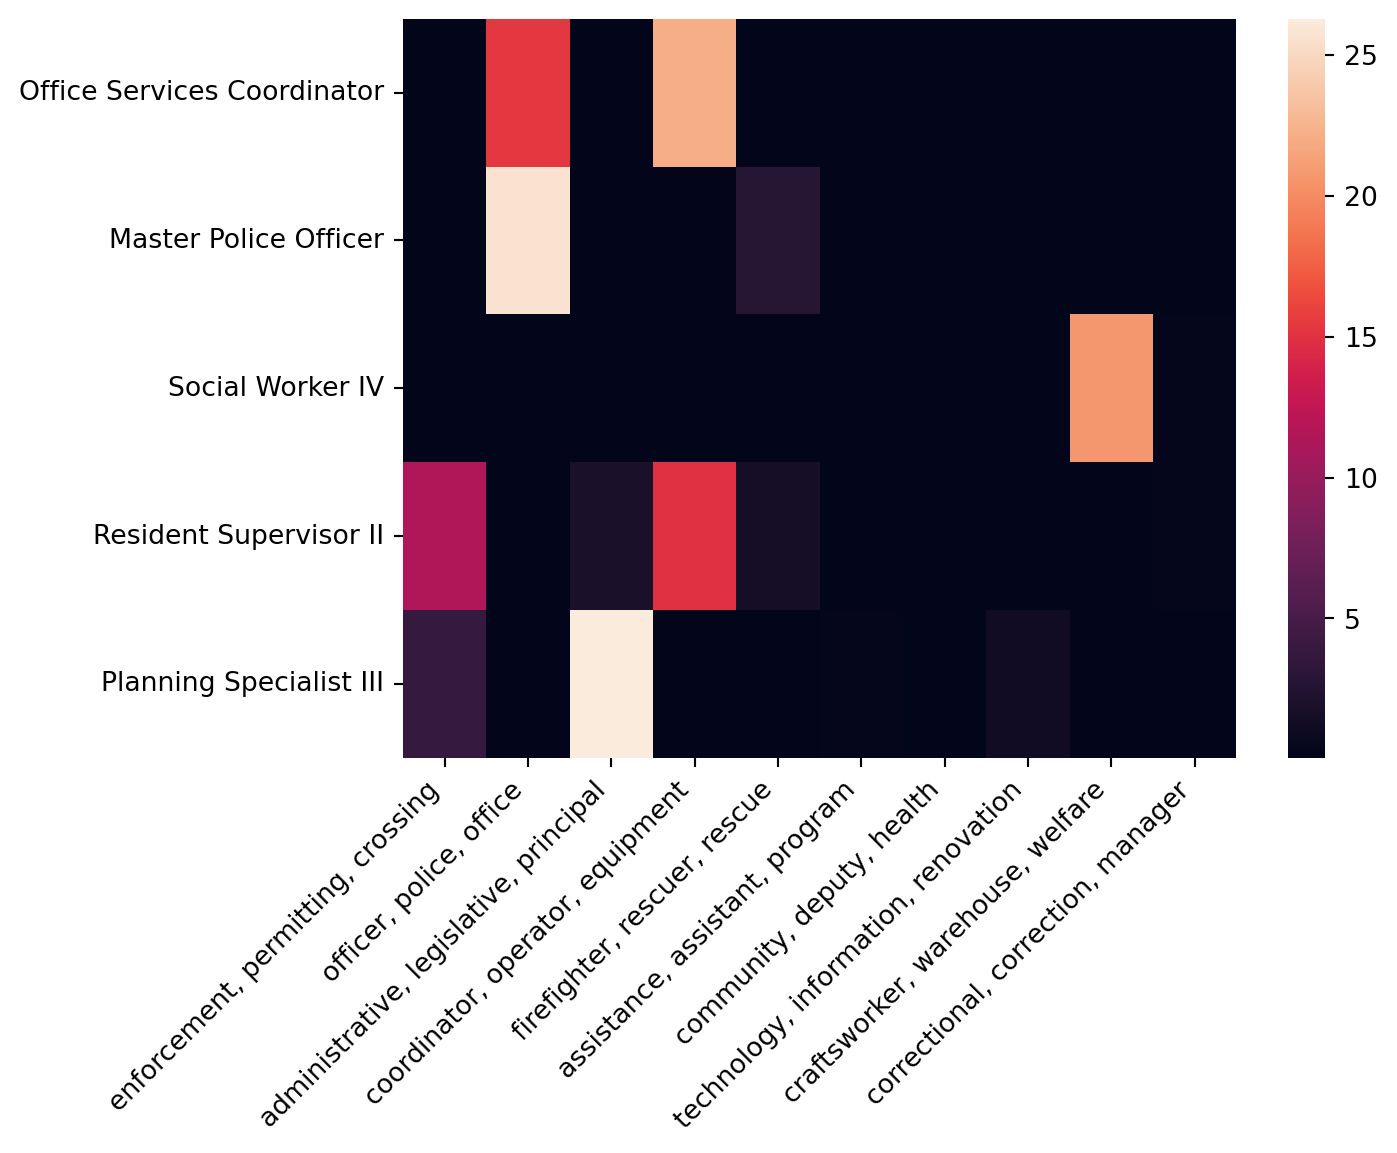

In [17]:
import seaborn as sns
from matplotlib import pyplot as plt

gap = skrub.GapEncoder()
pos_title = X["employee_position_title"]
loadings = gap.fit_transform(pos_title).set_index(pos_title.values).head()

loadings.columns = [c.split(": ")[1] for c in loadings.columns]
sns.heatmap(loadings)
_ = plt.setp(plt.gca().get_xticklabels(), rotation=45, ha="right")

### `TextEncoder`

Extract embeddings from a text column using any model from the HuggingFace Hub.

<Axes: >

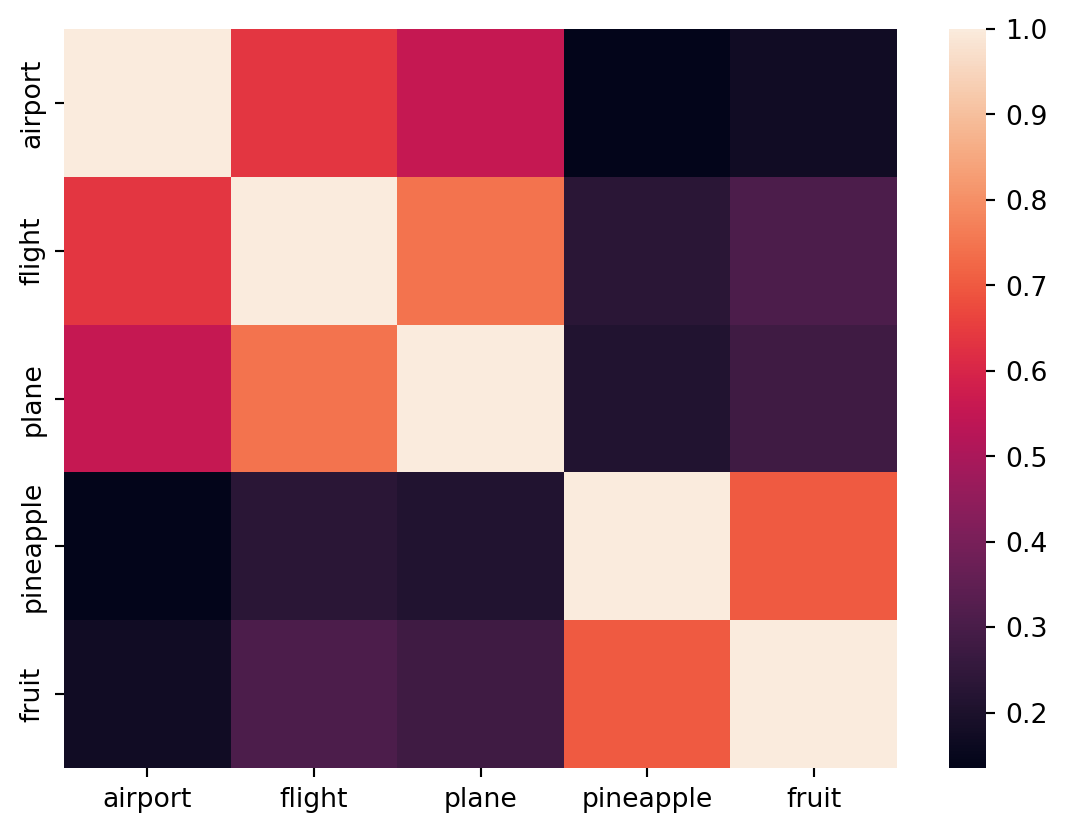

In [18]:
import pandas as pd

X = pd.Series(["airport", "flight", "plane", "pineapple", "fruit"])
encoder = skrub.TextEncoder(model_name="all-MiniLM-L6-v2", n_components=None)
embeddings = encoder.fit_transform(X).set_index(X.values)

sns.heatmap(embeddings @ embeddings.T)

### `MinHashEncoder`

A fast, stateless way of encoding strings that works especially well with
models based on decision trees (gradient boosting, random forest).

# 4. How do I bring it all together?

Skrub has several transformers that allow peforming typical dataframe
operations such as projections, joins and aggregations _inside a scikit-learn pipeline_.

Performing these operations in the machine-learning pipeline has several advantages:

- Choices / hyperparameters can be optimized
- Relevant state can be stored to ensure consistent transformations
- All transformations are packaged together in an estimator

There are several transformers such as `SelectCols`, `Joiner` (fuzzy joining),
`InterpolationJoiner`, `AggJoiner`, ...

A toy example using the `AggJoiner`:

In [19]:
from skrub import AggJoiner

airports = pd.DataFrame(
    {
        "airport_id": [1, 2],
        "airport_name": ["Charles de Gaulle", "Aeroporto Leonardo da Vinci"],
        "city": ["Paris", "Roma"],
    }
)
airports

airport_id                 airport_name   city
0           1            Charles de Gaulle  Paris
1           2  Aeroporto Leonardo da Vinci   Roma

In [20]:
flights = pd.DataFrame(
    {
        "flight_id": range(1, 7),
        "from_airport": [1, 1, 1, 2, 2, 2],
        "total_passengers": [90, 120, 100, 70, 80, 90],
        "company": ["DL", "AF", "AF", "DL", "DL", "TR"],
    }
)
flights

flight_id  from_airport  total_passengers company
0          1             1                90      DL
1          2             1               120      AF
2          3             1               100      AF
3          4             2                70      DL
4          5             2                80      DL
5          6             2                90      TR

In [21]:
agg_joiner = AggJoiner(
    aux_table=flights,
    main_key="airport_id",
    aux_key="from_airport",
    cols=["total_passengers"],
    operations=["mean", "std"],
)
agg_joiner.fit_transform(airports)

airport_id                 airport_name   city  total_passengers_mean  \
0           1            Charles de Gaulle  Paris             103.333333   
1           2  Aeroporto Leonardo da Vinci   Roma              80.000000   

   total_passengers_std  
0             15.275252  
1             10.000000

## More interactive and expressive pipelines

To go further than what can be done with scikit-learn Pipelines and the skrub
transformers shown above, we are developing new utilities to easily define
and inspect flexible pipelines that can process several dataframes.

A prototype will be shown in a separate notebook.